# Demo notebook for closed loop moves
We start with some standard imports.  Setting the loglevel to INFO means we'll see logs from long running tasks on the microscope.

In [3]:
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time
import requests
import json
import logging
logging.getLogger().setLevel("INFO")

Now that the basic calibration routines are in the microscope software, it's time to make use of them!  We've already got a ``move_in_image_coordinates`` function, but there is a lot more that can be done.

INFO:root:Connecting to microscope 192.168.0.48:5000
INFO:root:Error while changing resolution: Recording already running.
INFO:root:Error while starting preview: Recording already running.
INFO:root:Joining JPEG thread


Active microscope extensions
  * org.openflexure.autofocus
  * org.openflexure.autostorage
  * org.openflexure.camera_stage_mapping
  * org.openflexure.calibration.picamera
  * org.openflexure.scan
  * org.openflexure.zipbuilder
  * org.openflexure.medscan


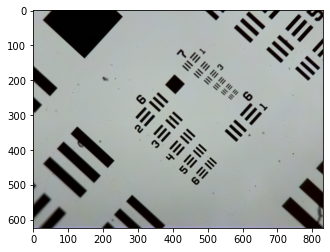

In [4]:
import openflexure_microscope_client
#microscope = openflexure_microscope_client.find_first_microscope()
microscope = openflexure_microscope_client.MicroscopeClient("192.168.0.48")

# Jiggle the stage to check it's all OK
pos = microscope.position
starting_pos = pos.copy()
pos['x'] += 100
microscope.move(pos)
assert microscope.position == pos
pos['x'] -= 100
microscope.move(pos)
assert microscope.position == starting_pos

# Check the microscope will autofocus
ret = microscope.autofocus()

# Acquire an image for sanity-checking too
image = microscope.grab_image()
f, ax = plt.subplots(1,1)
ax.imshow(np.array(image))
#print(image.metadata)
print("Active microscope extensions")
for k in microscope.extensions.keys():
    print("  * " + k)

# Calibrating the stage to the camera
Before we can do anything fancier, we need to make sure we understand the relationship between a step of the stage, and position in the image.  The next cell performs such a calibration.  NB this is using the microscope's plugin and **not** the code on your computer.

In [5]:
start_time = time.time()

cal = microscope.calibrate_xy()

print(f"Calibrated microscope in {time.time() - start_time}")

INFO:root:Calibrating X axis:
INFO:root:Moving the stage until we see motion...
INFO:root:Moving the stage to the edge of the field of view...
INFO:root:Moving the stage backwards to measure backlash (1/2)
INFO:root:Moving the stage forwards to measure backlash (2/2)
INFO:root:Moving back to the start, correcting for backlash...
INFO:root:Estimated backlash 126 steps
INFO:root:Stage-to-image ratio 0.104 pixels/step
INFO:root:Residuals were about 0.02 times the step size
INFO:root:Calibrating Y axis:
INFO:root:Moving the stage until we see motion...
INFO:root:Moving the stage to the edge of the field of view...
INFO:root:Moving the stage backwards to measure backlash (1/2)
INFO:root:Moving the stage forwards to measure backlash (2/2)
INFO:root:Moving back to the start, correcting for backlash...
INFO:root:Estimated backlash 95 steps
INFO:root:Stage-to-image ratio 0.110 pixels/step
INFO:root:Residuals were about 0.01 times the step size
INFO:root:Updating settings with {'extensions': {'o

Calibrated microscope in 284.3140525817871


Text(0.5, 0.98, 'Y calibration')

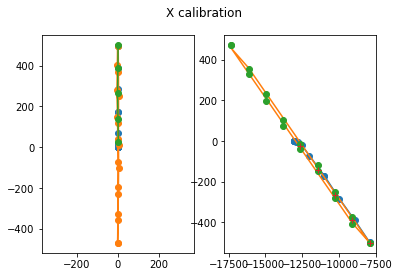

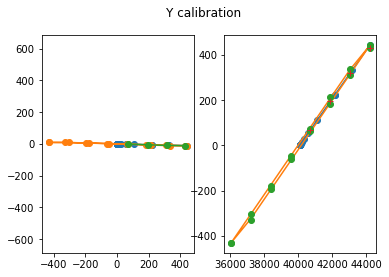

In [6]:
from camera_stage_mapping import camera_stage_calibration_1d
f, _ax = camera_stage_calibration_1d.plot_1d_backlash_calibration(cal["linear_calibration_x"])
f.suptitle("X calibration")
f, _ax = camera_stage_calibration_1d.plot_1d_backlash_calibration(cal["linear_calibration_y"])
f.suptitle("Y calibration")

# Playing with tracking
Now that we've calibrated the microscope, we can use the ``move_in_image_coordinates`` function to move by an approximately-known distance in pixels.  We use this to acquire two images with a known-ish displacement, so we can test out the correlation code.  NB this is cheating, because the correlation code we're "testing" is probably the code that generated the calibration we're using...

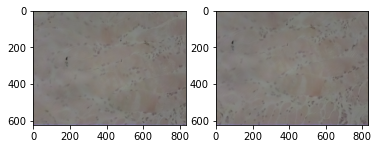

In [30]:
def move_in_pixels(x, y):
    microscope.extensions["org.openflexure.camera_stage_mapping"]["move_in_image_coordinates"].post_json({'x':x, 'y':y})

move_in_pixels(-100,-100)
move_in_pixels(100,100)
initial_image = microscope.grab_image_array()
move_in_pixels(100,100)
image_a = microscope.grab_image_array()
move_in_pixels(-100,-100)

f, ax = plt.subplots(1,2)
ax[0].imshow(initial_image)
ax[1].imshow(image_a)

Correlation between the two images can be done efficiently in the Fourier domain.  This involves a few steps:
1. Convert to grayscale
1. Take the FFT (NB as the input is real, we may save some work by computing only one quadrant of the result, using ``np.fft.rfft2`` instead of the regular ``fft2``
1. Implement the high pass filter by zeroing out the low frequency components
1. Multiply the two FFT-ed images together
1. Perform the inverse transform

The Fourier filter possibly bears some explanation.  In image space, what we're doing is convolving the image with a Gaussian (to blur it), then subtracting the blurred image from the original.  That should remove the low frequency components, while preserving the high frequencies.  In Fourier space, the convolution becomes a multiplication, and the Gaussian's size changes (its width in the Fourier domain is inversely proportional to its real-space width).  We use padding (doubling the size of the image, and filling it in with zeros) to remove ambiguity from the tracking.

This code all lives in ``camera_stage_mapping.fft_image_tracking``, see the module's source (or documentation when it exists) for more detail.  The code below tracks motion between the two images we acquired above.

In [31]:
from camera_stage_mapping.fft_image_tracking import displacement_between_images

disp = displacement_between_images(initial_image, image_a)
print(f"The recovered displacement was {disp[0]:.2f}, {disp[1]:.2f}")

The recovered displacement was -87.78, -92.81


We can test for convergence by varying the threshold and looking at how the recovered shift changes - too low a threshold should tend towards 0, too high a threshold should be close to the right value, but a bit noisy.

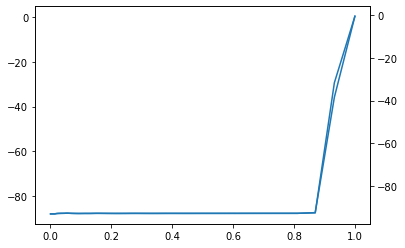

In [32]:
from camera_stage_mapping.fft_image_tracking import background_subtracted_centre_of_mass, high_pass_fft_template, grayscale_and_padding

template = high_pass_fft_template(initial_image)
image_a_gray, fft_shape = grayscale_and_padding(image_a, True)
corr = np.fft.irfft2(template * np.fft.rfft2(image_a_gray, s=fft_shape))

ts = 10**np.linspace(0, -3, 100)
points = np.zeros((len(ts), 2))
for i, t in enumerate(ts):
    points[i, :] = background_subtracted_centre_of_mass(corr, t, True)
f, ax = plt.subplots(1,1)
ax.plot(ts, points[:,0])
ax.twinx().plot(ts, points[:,1])

# Thresholding check
As a useful sanity check, and an exercise in interactive plotting, the code below lets me vary the threshold, and see both the thresholded image, and the resulting position.  NB this requires the ``%matplitlib notebook`` or the use of an interactive matplotlib plot, so in some notebook viewers it may not work.

In [ ]:
%matplotlib notebook
from matplotlib.widgets import Slider, Button, RadioButtons
fig, ax = plt.subplots(1,1)
plt.subplots_adjust(bottom=0.25)

ax_thresh = plt.axes([0.25, 0.05, 0.65, 0.03])

    

slider_thresh = Slider(ax_thresh, 'Fractional Threshold', 0, 3, valinit=1, valstep=0.001)


def update(values):
    t = 10**(-slider_thresh.val)
    thresholded = corr.copy()
    background = np.max(corr) - t * (np.max(corr) - np.min(corr))
    thresholded[corr < background] = 0
    ax.cla()
    ax.imshow(thresholded, vmax=corr.max(), vmin=0)
    x, y = background_subtracted_centre_of_mass(corr, t)
    ax.plot(y, x, "o", color="red")
    fig.canvas.draw_idle()
update(None)
    
slider_thresh.on_changed(update)

To check we're getting an accurate reading, count the number of nonzero pixels - 100 would be nice, 1 is worrying.

In [ ]:
t = 10**(-slider_thresh.val)
background = np.max(corr) - t * (np.max(corr) - np.min(corr))
print(f"There are {np.sum(corr >= background)} nonzero pixels")

# A simple test of our displacement sensor
To test this out, let's do a little experiment.  We'll take a template image, then move the stage in 10 steps of 50 pixels.  After doing this, we should have made it wrap - but hopefully it moves in the way we expect.  What we expect is that it should give an accurate result until we move by half the field of view (i.e. 316 pixels in y, or 212 in x), then "wrap" back by one whole image width/height.  After it's moved by almost a whole image, we expect that the signal is nonsense.

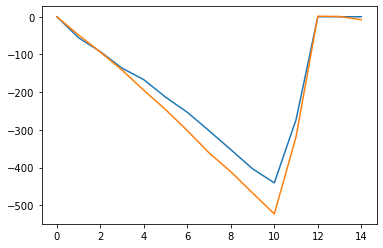

In [33]:
from camera_stage_mapping.fft_image_tracking import displacement_from_fft_template
move_in_pixels(-100,-100)
move_in_pixels(100,100)

template = high_pass_fft_template(microscope.grab_image_array())
positions = [displacement_from_fft_template(template, microscope.grab_image_array())]
for i in range(14):
    move_in_pixels(50, 50)
    positions.append(displacement_from_fft_template(template, microscope.grab_image_array()))
move_in_pixels(-800,-800)
move_in_pixels(100,100)
positions = np.array(positions)
f, ax = plt.subplots(1,1)
ax.plot(positions[:,0])
ax.plot(positions[:,1])

# Making a closed-loop move
In order to make a closed loop move of a bit less than one field of view, we should:
1. Calculate the expected overlap between the initial and final positions
1. Check the overlap is large enough (in future, this could trigger a multi-step move)
1. Take an initial image
1. Make the move (open loop for now, assuming we are fully-wound-up)
1. Take an image
1. Check the actual position by referencing the initial image against the image we just took
1. If we have not moved far enough, move a bit farther.

The problem comes if we've overshot, and I think the key is taking care of our tolerances.  Overshooting slightly in a tiled scan is not a big problem.  If we really need tight tolerances, we should do a combination of deliberately undershooting (moving a bit less than intended) and taking backlash into account when changing direction.

In [34]:
from camera_stage_mapping.camera_stage_tracker import Tracker

from numpy.linalg import norm
def move_in_pixels_array(pos):
    move_in_pixels(int(pos[0]), int(pos[1]))

def closed_loop_move(tracker, move_in_pixels, pos, tolerance=5, max_iterations=3):
    """Move by a specified distance in pixels"""
    pos = np.array(pos)
    if not tracker.point_in_safe_range(pos):
        raise ValueError("closed_loop_move can only move by the maximum distance we can track.")
                  
    move_in_pixels(pos - tracker.image_positions[-1]) # Initial (open loop) move
    iterations = 0
    stage_pos, image_pos = tracker.append_point()
    while norm(image_pos - pos) > tolerance and iterations < max_iterations:
        move_in_pixels(pos - image_pos)
        stage_pos, image_pos = tracker.append_point()
        iterations += 1
        if iterations > max_iterations:
            logging.warn(f"Closed loop move did not converge in {max_iterations} iterations.")
            break
    return image_pos

                  

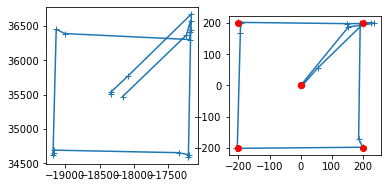

In [35]:
pos = np.array([200, 200])
tracker = Tracker(microscope.grab_image_array, microscope.get_position_array, method="fft")
tracker.acquire_template()
closed_loop_move(tracker, move_in_pixels_array, pos * [1, 1])
closed_loop_move(tracker, move_in_pixels_array, pos * [1, -1])
closed_loop_move(tracker, move_in_pixels_array, pos * [-1, -1])
closed_loop_move(tracker, move_in_pixels_array, pos * [-1, 1])
closed_loop_move(tracker, move_in_pixels_array, pos * [1, 1])
closed_loop_move(tracker, move_in_pixels_array, (0, 0))

f, ax = plt.subplots(1,2)
for positions, axes in zip(tracker.history, ax):
    axes.plot(positions[:,0], positions[:,1], "+-")
    axes.set_aspect(1)

ax[1].plot(np.array([0, 1, 1, -1, -1, 0]) * pos[0], np.array([0, 1, -1, -1, 1, 0]) * pos[1], "ro")

Everything works nicely, until the tracking fails and we go haywire.  What would be great is a sanity check on the tracking.  Possibly just checking that the error we've detected isn't too big would be a good start (how big is too big?), but I thought it would be nice to do a quick sanity check on the centre of mass measurement.  Together with Ed, we discussed two sensible strategies:
* vary the threshold, and check for convergence
* keep the threshold fixed but check the points above the threshold are close together

Another sensible strategy might be to predict what the maximum signal we'd expect is (i.e. when we set the template, do a tracking step and calculate the maximum signal).  That has the advantage of nearly zero marginal cost in speed, so let's try that for now.

We can test it out by moving the stage and tracking the correlation score; it should drop off more or less linearly with the area overlap between the template image and the final image.

C:\Users\rwb34\dev\camera-stage-mapping\.venv\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


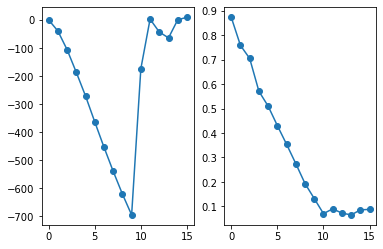

In [36]:
import camera_stage_mapping.fft_image_tracking as ft
template = ft.high_pass_fft_template(microscope.grab_image_array())
scores = []
positions = []

starting_pos = microscope.get_position_array()
for i in range(16):
    if i>0:
        move_in_pixels(0, 80)
    pos, s = ft.displacement_from_fft_template(template, microscope.grab_image_array(), return_peak=True)
    positions.append(pos)
    scores.append(s)

microscope.move(starting_pos)

positions = np.array(positions)

f, ax = plt.subplots(1,2)
ax[0].plot(positions[:,1], 'o-')
ax[1].plot(scores/template.attrs["maximum_correlation_value"], 'o-')

We can add basic error detection by checking the correlation score is non-stupid.  It should be not too much different from the expected overlap between the images.  There's a default 0.2 threshold now in the tracking code, if we drop below that, we'll raise an exception and stop.

Now, let's try a snake scan with error-detection:

INFO:root:moving to [0 0]
INFO:root:moving to [  0 300]
INFO:root:moving to [  0 600]
INFO:root:moving to [  0 900]
INFO:root:moving to [300 900]
INFO:root:moving to [300 600]
INFO:root:moving to [300 300]
INFO:root:moving to [300   0]
INFO:root:moving to [600   0]
INFO:root:moving to [600 300]
INFO:root:moving to [600 600]
INFO:root:moving to [600 900]
INFO:root:moving to [900 900]
The correlation signal dropped below the threshold set.


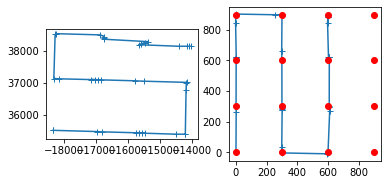

In [40]:
# This code is a bit old - try the newer code below, based on closed_loop_scan
from camera_stage_mapping.camera_stage_tracker import TrackingError
spacing = np.array((300,300))
N = 4
snake_path = []
for i in range(N):
    line = [(i, j) * spacing for j in range(N)]
    if i % 2 > 0:
        line = reversed(line)
    snake_path += line

tracker = Tracker(microscope.grab_image_array, microscope.get_position_array, method="fft", pad=True, error_threshold=0.2)
tracker.acquire_template()
initial_position = tracker.stage_positions[-1]

try:
    for p in snake_path:
        logging.info(f"moving to {p}")
        closed_loop_move(tracker, move_in_pixels_array, p)
        tracker.leapfrog()
except TrackingError as e:
    print(e)
finally:
    microscope.move(initial_position)

f, ax = plt.subplots(1,2)
for positions, axes in zip(tracker.history, ax):
    axes.plot(positions[:,0], positions[:,1], "+-")
    axes.set_aspect(1)

snake_path = np.array(snake_path)

ax[1].plot(snake_path[:,0], snake_path[:,1], "ro")


In [42]:
from camera_stage_mapping.closed_loop_move import closed_loop_scan
from camera_stage_mapping.scan_coords_times import ordered_spiral

tracker = Tracker(microscope.grab_image_array, microscope.get_position_array, method="fft")
tracker.acquire_template()

scan_path = ordered_spiral(0,0, 3, 300, 300)
for i, pos in closed_loop_scan(tracker, move_in_pixels_array, microscope.move, np.array(scan_path)):
    print(f"Arrived at scan point {i}, {pos}")

INFO:root:Closed loop scan (0/25): target position [0 0], actual position [-0.15936113 -0.13247005], diff [-0.15936113 -0.13247005]
Arrived at scan point 0, [-0.15936113 -0.13247005]
INFO:root:Closed loop scan (1/25): target position [  0 300], actual position [  0.72221244 305.3881702 ], diff [0.72221244 5.3881702 ]
Arrived at scan point 1, [  0.72221244 305.3881702 ]
INFO:root:Closed loop scan (2/25): target position [300 300], actual position [298.24626946 297.63690577], diff [-1.75373054 -2.36309423]
Arrived at scan point 2, [298.24626946 297.63690577]
INFO:root:Closed loop scan (3/25): target position [300   0], actual position [300.96385581  -4.13623602], diff [ 0.96385581 -4.13623602]
Arrived at scan point 3, [300.96385581  -4.13623602]
INFO:root:Closed loop scan (4/25): target position [ 300 -300], actual position [ 307.34050806 -309.46953857], diff [ 7.34050806 -9.46953857]
Arrived at scan point 4, [ 307.34050806 -309.46953857]
INFO:root:Closed loop scan (5/25): target positio

It would be nice if I'd broken this up into individual moves, so I could record the position each image would have been taken at...

Without correction, RMS error was 33.26972119407281 pixels.
After correction, RMS error was 7.458070347337632 pixels.


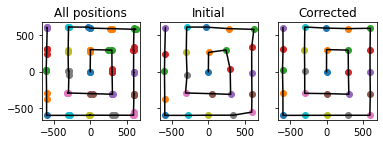

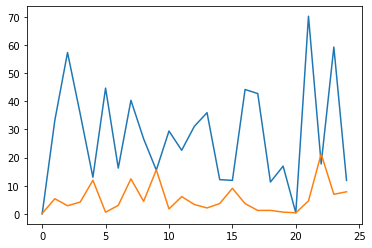

In [68]:
stage_pos, camera_pos = tracker.history
moves = []
move_indices = np.zeros(camera_pos.shape[0], dtype=int)
for i in range(camera_pos.shape[0]):
    move_indices[i] = np.argmin(np.sum((scan_path - camera_pos[i,:])**2, axis=1))

# move_indices should be monotonic, starting at the first index and moving to the next
# until we're done.
assert np.min(move_indices) == 0
assert np.all(np.diff(move_indices) >= 0)
assert np.all(np.diff(move_indices) <= 1)

for i in range(np.max(move_indices) + 1):
    moves.append(camera_pos[move_indices==i, :])

f, ax = plt.subplots(1,3, sharex=True, sharey=True)

initial_positions = np.array([m[0] for m in moves])
final_positions = np.array([m[-1] for m in moves])
all_positions = np.concatenate(moves)

# Plot the scan points
for i, m in enumerate(moves):
    for j, rr in enumerate([slice(None), 0, -1]):
        ax[j].plot(m[rr,0], m[rr,1], "o-")
# Plot the scan paths
for i, p in enumerate([all_positions, initial_positions, final_positions]):
    ax[i].plot(p[:,0], p[:,1], color="black")

for axis, title in zip(ax, ["All positions", "Initial", "Corrected"]):
    axis.set_aspect(1)
    axis.set_title(title)

# Analyse error before and after correction
f, ax = plt.subplots(1,1)
for desc, positions in [("Without", initial_positions),
                        ("After", final_positions)]:
    errors = np.sum((positions - np.array(scan_path))**2, axis=1)**0.5
    ax.plot(errors)
    print(f"{desc} correction, RMS error was {np.mean(errors**2)**0.5} pixels.")

In [61]:
np.sum(np.diff(move_indices))

24